In [9]:
import pandas as pd
import numpy as np
import random
import pickle
import os, re, ast

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from itertools import combinations 
from sklearn.manifold import TSNE
#from bokeh.plotting import figure, show, output_notebook, save
#from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

from sklearn import preprocessing
from collections import OrderedDict
import sys
from scipy import spatial


In [10]:
def back_to_list(df,columns):
    """Convert columns in df back to lists from strings (this happens when saving to csv)
    """
    df.fillna('', inplace=True)

    for col in columns:
        if isinstance(df[col][0], str):
            df[col] = [ast.literal_eval(s) for s in df[col]]

    return df

In [11]:
# Load education and occupation details

jobs_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/jobbank-fields.csv')
details_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/job-description.csv')
job_name_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/education-to-job.csv')


In [12]:
job_name_df

,edu_level,education_groups,top_jobs,job_percent,top_job_links,link,identifier,noc
0,College/CEGEP,Accounting,Accounting and related clerks,11.99,/marketreport/summary-occupation/14122/ca,/14122/ca,Accounting: College/CEGEP,1431.0
1,College/CEGEP,Accounting,Financial auditors and accountants,11.23,/marketreport/summary-occupation/131/ca,/131/ca,Accounting: College/CEGEP,1111.0
2,College/CEGEP,Accounting,Accounting technicians and bookkeepers,10.46,/marketreport/summary-occupation/24500/ca,/24500/ca,Accounting: College/CEGEP,1311.0
3,College/CEGEP,Accounting,Administrative officers,3.92,/marketreport/summary-occupation/12462/ca,/12462/ca,Accounting: College/CEGEP,1221.0
4,College/CEGEP,Accounting,Retail salespersons,3.25,/marketreport/summary-occupation/20599/ca,/20599/ca,Accounting: College/CEGEP,6421.0
...,...,...,...,...,...,...,...,...
1940,Master's degree,Sociology,Administrative officers,2.63,/marketreport/summary-occupation/12462/ca,/12462/ca,Sociology: Master's degree,1221.0
1941,Master's degree,Sociology,Social and community service workers,2.63,/marketreport/summary-occupation/5112/ca,/5112/ca,Sociology: Master's degree,4212.0
1942,Master's degree,Sociology,Business development officers and marketing re...,2.63,/marketreport/summary-occupation/3916/ca,/3916/ca,Sociology: Master's degree,4163.0
1943,Master's degree,Sociology,University professors and lecturers,1.97,/marketreport/summary-occupation/4707/ca,/4707/ca,Sociology: Master's degree,4011.0


In [5]:
jobs_df['description'].str.split('found under ')
edu_categories = [s.split('found under ')[1] for s in jobs_df['description']]
edu_categories = [s.strip('.') for s in edu_categories]
jobs_df['education_groups'] = edu_categories

jobs_df = back_to_list(jobs_df, ['top_jobs','top_job_links','job_percent'])

education_df = jobs_df[['degree','education_groups','top_jobs','job_percent']].drop_duplicates(subset =['education_groups','degree'])


In [6]:
#details_df = back_to_list(details_df, ['duties','titles'])

In [7]:
merged_df = pd.merge(left=job_name_df[['top_jobs','link']], 
                     right=details_df[['link','description','duties']], 
                     how='left', 
                     left_on='link', 
                     right_on='link')

train_df = merged_df.drop_duplicates(subset =['top_jobs','link'])

train_df
    

KeyError: "['link'] not in index"

# Preprocessing text columns

In [105]:
def preprocess(text):
    """ preprocess text: remove special characters, remove digits, tokenize,
    lowercase, remove stopwords, lemmatize
    """
    # preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
    tokenizer = RegexpTokenizer(r'\w+')
    stopwords_en = list(stopwords.words('english'))
    stopwords_en.extend(['work','works','worker','workers',
                         'activity','may','employed',
                         'company','companies',
                         'occupations','occupation','related'])
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens if len(token)>1]
    token_result = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]

    return ' '.join(token_result)


In [106]:
# preprocess job title and description
for col in ['top_jobs','description','duties']:
    train_df[col] = train_df[col].astype(str)
    train_df[col+'_processed'] = train_df[col].apply(preprocess)

# have a column for both title and descritpion
cols = ['description_processed','duties_processed']
train_df['duties_and_desc'] = train_df[cols].apply(lambda x: ' '.join(x), axis=1)


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is tr

In [107]:
def plot_common_words(df, column, n):
    """plot n most common words in a column of a df"""
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of n most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel('word')
    plt.xlabel('count')
    plt.title('Frequency of'+' '+str(n)+' '+'most common words in {}'.format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

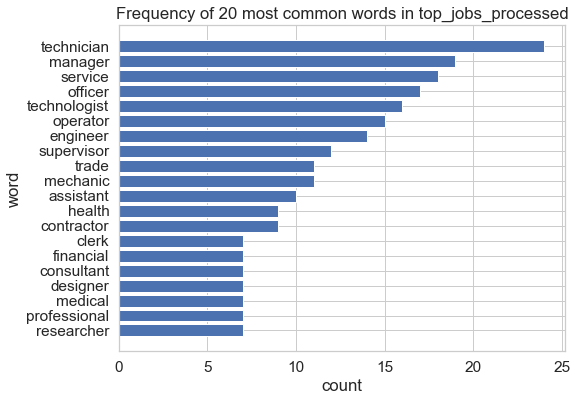

In [108]:
# plot most common words in job titles
sns.set(style='whitegrid', font_scale=1.4)
plot_common_words(train_df, 'top_jobs_processed', 20)

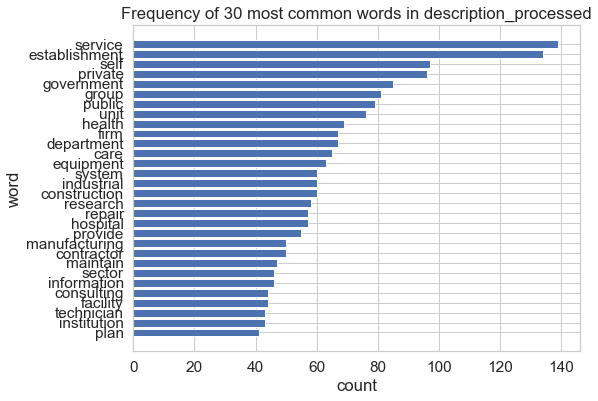

In [109]:
plot_common_words(train_df, 'description_processed', 30)

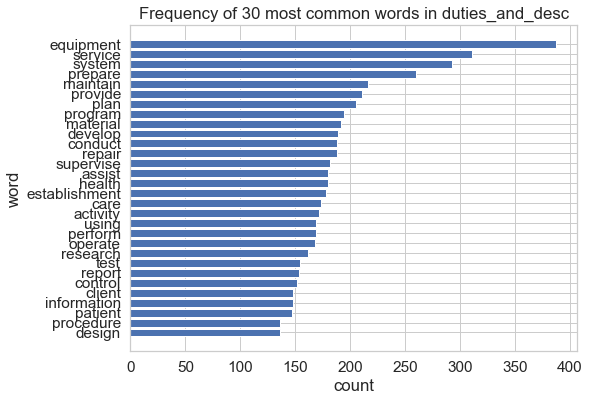

In [110]:
plot_common_words(train_df, 'duties_and_desc', 30)

In [111]:
# vectorize job description - for work_exp df
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000)
job_description_vec = vectorizer.fit_transform(train_df['duties_and_desc'])

In [112]:
def multiple_nmf(kmin, kmax, vec_text):
    """run multiple nmf models with a chosen range of number of components,
    return a list XXXXX
    
    kmin -- minimum number of topics
    kmax -- maximum number of topics
    vec_text -- vectorized text
    """
    topic_models = []
    for k in range(kmin, kmax+1):
        print("Applying NMF for k=%d ..." % k)
        nmf = NMF(n_components=k,
                  init="nndsvd",
                  alpha=0.1,
                  random_state=42) 
        W = nmf.fit_transform(vec_text)
        H = nmf.components_    
        topic_models.append((k, nmf, W, H))
    
    return topic_models

In [113]:
topic_models = multiple_nmf(10, 30, job_description_vec)

Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...


In [114]:
# convert job_description_processed to a list of lists for word2vec model
job_desc_train = train_df['duties_and_desc'].apply(lambda x: x.split(' ')).tolist()

# train word2vec model
word2vec_model = Word2Vec(job_desc_train,
                          size=200,
                          window=8,
                          min_count=5,
                          workers=4)
word2vec_model.train(job_desc_train, total_examples=len(job_desc_train), epochs=10)

(293851, 378750)

In [115]:
# have a look at the word2vec results
word2vec_model.wv.most_similar(positive='clean')

[('body', 0.9847539663314819),
 ('instrument', 0.9832314252853394),
 ('set', 0.9817736148834229),
 ('polish', 0.9815053939819336),
 ('remove', 0.98091059923172),
 ('fit', 0.9798281192779541),
 ('calibrate', 0.9777595400810242),
 ('apply', 0.9755368828773499),
 ('apparatus', 0.9746394157409668),
 ('maintain', 0.9694558382034302)]

In [116]:
def get_top_terms(vectorizer, H, n_top_terms):
    """get terms most important for each of the topics of an nmf model
    return a dictionary with topic number as key and a list of top terms as values
    
    vectorizer -- vectorizer for text
    H -- topic term matrix from nmf model
    n_top_terms -- number of top words to choose
    """
    terms = vectorizer.get_feature_names()
    
    top_terms_dict = {};
    # for each topic, get the largest weights, and save the corresponding words into the dictionary
    num_topics = H.shape[0]
    for i in range(num_topics):
        ids = H[i].argsort()[-n_top_terms:] 
        # word_ids is ordered such that largest weight is the last item, reverse it to have it as first item
        top_terms_dict['Topic '+'{:01d}'.format(i+1)] = [terms[id] for id in reversed(ids)]
        
    return top_terms_dict

def compute_coherence(word2vec_model, top_terms_dict):
    """compute coherence score, ie, mean pairwise similarity of top terms
    
    word2vec_model -- word2vec model trained on words in dataset
    top_term_dict -- top words of each topic (output of get_top_terms() function)
    """
    overall_coherence = 0.0
    num_topics = len(top_terms_dict)
    for i in range(num_topics):
        pair_scores = []
        # compute similarity score for each pair of top words in each topic
        for pair in combinations(top_terms_dict['Topic '+'{:01d}'.format(i+1)], 2):
            pair_scores.append(word2vec_model.wv.similarity(pair[0], pair[1]))
        
        topic_score = sum(pair_scores)/len(pair_scores)
        overall_coherence += topic_score
    
    # get mean score across topics
    return overall_coherence/num_topics

def compare_coherence(topic_models, vectorizer, n_top_terms, word2vec_model):
    """get topic coherence for multiple nmf models
    
    topic_models -- output of multiple_nmf() function
    """
    coherence_dict = {}
    for i in range(len(topic_models)):
        top_terms_dict = get_top_terms(vectorizer, topic_models[i][3], n_top_terms) # 4th element of each list in topic_models: H     
        
        k = topic_models[i][0] # first element of each list in topic models: k
        coherence = compute_coherence(word2vec_model, top_terms_dict)
        print("K=%02d: Coherence=%.4f" % (k, coherence))
        coherence_dict[k] = coherence
        
    return coherence_dict

In [117]:
# get top words for each of 20 topics
best_k = 20
top_words = pd.DataFrame(get_top_terms(vectorizer, topic_models[best_k-10][3], 15))
W = topic_models[best_k-10][2]

In [118]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [119]:
# have a look at top words in each of the 20 topics
top_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
0,contractor,electrical,patient,construction,sale,install,office,social,chemical,financial,student,manager,forest,animal,equipment,food,production,metal,software,insurance
1,co,system,care,engineering,good,wall,document,program,conduct,investment,teacher,organize,tree,farm,operate,beverage,television,part,information,claim
2,ordinate,equipment,health,design,retail,concrete,library,client,research,credit,school,direct,forestry,veterinarian,heavy,cook,radio,machine,system,coverage
3,schedule,repair,medical,project,service,surface,record,service,process,accounting,secondary,evaluate,lawn,laboratory,truck,kitchen,picture,tool,computer,premium
4,activity,test,treatment,building,wholesale,using,administrative,community,plant,loan,teach,plan,landscape,livestock,crane,patron,video,product,network,agent
5,recommend,component,physician,prepare,customer,floor,legal,policy,environmental,trust,language,department,fire,veterinary,material,bar,motion,repair,data,automobile
6,trade,power,hospital,civil,merchandise,building,procedure,agency,analysis,account,subject,human,landscaping,health,move,restaurant,theatre,sheet,design,individual
7,supervisor,electronic,nursing,specification,sell,apply,correspondence,health,study,security,teaching,control,reforestation,care,transport,chef,film,welding,develop,risk
8,supervise,install,nurse,drawing,product,furniture,telephone,sport,laboratory,banking,elementary,policy,landscaped,breeding,construction,dish,dance,machining,hardware,policy
9,business,maintenance,dental,mechanical,establishment,tile,information,provide,well,stock,vocational,resource,survey,crop,operator,staff,news,dimension,technology,property


In [ ]:
# Initialize dictionary with descriptions for each topic
topic_dict = {'Topic1':'Supervisory activities',
              'Topic2':'Electrical',
              'Topic3':'Healthcare',
              'Topic4':'Construction',
              'Topic5':'Sales',
              'Topic6':'Public service',
              'Topic7':'Information technology',
              'Topic8':'Mechanical repair',
              'Topic9':,'Chemistry'
              'Topic10':'Management',
              'Topic11':'Finance',
              'Topic12':'Machine operation',
              'Topic13':'Education',
              'Topic14':'Food service',
              'Topic15':'Farming and agriculture',
              'Topic16':'Archival endeavours',
              'Topic17':'Media',
              'Topic18':'Mining and energy',
              'Topic19':'Aviation and transport',
              'Topic20':'Office work'}



In [113]:
# have a df for document topic matrix, merge with df_work
W = topic_models[best_k-10][2]

topic_weights = pd.DataFrame(W, columns=['Topic '+'{:01d}'.format(i+1) for i in range(best_k)])
topic_weights1 = pd.DataFrame.copy(topic_weights)
# normalize topic weights such that they sum to 1 for each ducoment/job description
topic_weights1 = topic_weights1.div(topic_weights1.sum(axis=1), axis=0)

# find top 3 topics for each document/job description
topic_weights1['highest_topic1'] = topic_weights.idxmax(axis=1)
topic_weights1['highest_topic2'] = topic_weights.T.apply(lambda x: x.nlargest(2).idxmin())
topic_weights1['highest_topic3'] = topic_weights.T.apply(lambda x: x.nlargest(3).idxmin())

df_work_train = pd.concat([train_df, topic_weights1], axis=1, sort=False)

In [114]:
df_work_train.head()

,top_jobs,link,description,duties,top_jobs_processed,description_processed,duties_processed,duties_and_desc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,highest_topic1,highest_topic2,highest_topic3
0,Accounting and related clerks,/14122/ca,"Accounting and related clerks calculate, prepa...","['Calculate, prepare and issue documents relat...",accounting related clerk,accounting related clerk calculate prepare pro...,calculate prepare issue document related accou...,accounting related clerk calculate prepare pro...,0.000000,0.029924,0.000000,0.014661,0.123299,0.0,0.066689,0.000000,0.000000,0.000000,0.284233,0.0,0.000000,0.002071,0.000000,0.021168,0.000000,0.000000,0.000000,0.457955,Topic 20,Topic 11,Topic 5
1,Financial auditors and accountants,/131/ca,Financial auditors examine and analyze the acc...,"['Financial auditors', 'Examine and analyze jo...",financial auditor accountant,financial auditor examine analyze accounting f...,financial auditor examine analyze journal ledg...,financial auditor examine analyze accounting f...,0.034264,0.008196,0.009858,0.009102,0.000000,0.0,0.032849,0.000000,0.000000,0.078184,0.576761,0.0,0.065641,0.004587,0.000000,0.000000,0.000000,0.000000,0.000000,0.180558,Topic 11,Topic 20,Topic 10
2,Accounting technicians and bookkeepers,/24500/ca,Accounting technicians and bookkeepers maintai...,"['Keep financial records and establish, mainta...",accounting technician bookkeeper,accounting technician bookkeeper maintain comp...,keep financial record establish maintain balan...,accounting technician bookkeeper maintain comp...,0.000000,0.023606,0.000000,0.000000,0.000000,0.0,0.000000,0.023546,0.000000,0.000000,0.502528,0.0,0.004043,0.006762,0.021967,0.042845,0.013863,0.000000,0.005086,0.355754,Topic 11,Topic 20,Topic 16
3,Administrative officers,/12462/ca,Administrative officers oversee and implement ...,['Oversee and co-ordinate office administrativ...,administrative officer,administrative officer oversee implement admin...,oversee co ordinate office administrative proc...,administrative officer oversee implement admin...,0.133257,0.000000,0.000000,0.000000,0.000000,0.0,0.015258,0.000000,0.087311,0.209895,0.000000,0.0,0.010847,0.025410,0.000000,0.000000,0.000000,0.007124,0.000000,0.510899,Topic 20,Topic 10,Topic 1
4,Retail salespersons,/20599/ca,"Retail salespersons sell, rent or lease a rang...","['Greet customers and discuss type, quality an...",retail salesperson,retail salesperson sell rent lease range techn...,greet customer discus type quality quantity me...,retail salesperson sell rent lease range techn...,0.000000,0.004690,0.018847,0.006750,0.842295,0.0,0.044854,0.000000,0.008179,0.000000,0.009920,0.0,0.000000,0.000000,0.001875,0.014151,0.000000,0.048439,0.000000,0.000000,Topic 5,Topic 18,Topic 7


In [33]:
job_name_df['top_job_links'].fillna('', inplace=True)

In [34]:
link_list = [i.split(';')[0] for i in job_name_df['top_job_links']]

job_name_df['top_job_links'] = link_list

In [99]:
def uniqueness(df1,df2,group):

    from scipy import spatial

    group_jobs = df1.where(df1['education_groups']==group).dropna().drop_duplicates(['top_jobs'])

    is_job = df2[df2.link.isin(group_jobs['link'])]

    not_job = df2[~df2.link.isin(group_jobs['link'].values)]
    not_job = not_job.dropna(subset=['top_jobs'])

    job_mean = (is_job.iloc[:,-23:-3]).mean(axis = 0, skipna = True)

    results = []
    similarity = []
    for i in range(len(not_job)):
        b = not_job.iloc[i,-23:-3]
        c_sim = 1 - spatial.distance.cosine(job_mean, b)
        similarity.append(c_sim)

    not_job['similarity'] = similarity

    sorted_df = not_job.sort_values(by=['similarity'],ascending=False)

    results = sorted_df['top_jobs'][0:10]

    return list(results)
    

In [100]:
results = uniqueness(job_name_df,df_work_train,'Accounting')

In [101]:
results

['Inspectors in public and environmental health and occupational health and safety',
 'Psychologists',
 'Central control and process operators, petroleum, gas and chemical processing',
 'Industrial engineering and manufacturing technologists and technicians',
 'Non-destructive testers and inspection technicians',
 'Natural and applied science policy researchers, consultants and program officers',
 'Photographers',
 'Computer programmers and interactive media developers',
 'Producers, directors, choreographers and related occupations',
 'User support technicians']

In [343]:
len(df_work_train)

327

In [115]:
job_name_df.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-1.csv', index=False)
df_work_train.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-2.csv', index=False)







In [89]:
df_work_train

,top_jobs,link,description,duties,top_jobs_processed,description_processed,duties_processed,duties_and_desc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,highest_topic1,highest_topic2,highest_topic3
0,Accounting and related clerks,/14122/ca,"Accounting and related clerks calculate, prepa...","['Calculate, prepare and issue documents relat...",accounting related clerk,accounting related clerk calculate prepare pro...,calculate prepare issue document related accou...,accounting related clerk calculate prepare pro...,0.000000,0.022678,0.000000,0.000000,0.012397,0.000000,0.000000,0.000000,0.000000,0.480814,0.484111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic 11,Topic 10,Topic 2
1,Financial auditors and accountants,/131/ca,Financial auditors examine and analyze the acc...,"['Financial auditors', 'Examine and analyze jo...",financial auditor accountant,financial auditor examine analyze accounting f...,financial auditor examine analyze journal ledg...,financial auditor examine analyze accounting f...,0.000000,0.000000,0.000000,0.015706,0.066030,0.002403,0.000000,0.003810,0.072132,0.180250,0.536716,0.025607,0.050411,0.000000,0.000000,0.046935,0.000000,0.000000,0.000000,0.000000,Topic 11,Topic 10,Topic 9
2,Accounting technicians and bookkeepers,/24500/ca,Accounting technicians and bookkeepers maintai...,"['Keep financial records and establish, mainta...",accounting technician bookkeeper,accounting technician bookkeeper maintain comp...,keep financial record establish maintain balan...,accounting technician bookkeeper maintain comp...,0.000000,0.000000,0.000000,0.000000,0.046545,0.039712,0.041699,0.000000,0.000000,0.369881,0.396227,0.001426,0.000000,0.000000,0.000000,0.005098,0.000000,0.020997,0.078416,0.000000,Topic 11,Topic 10,Topic 19
3,Administrative officers,/12462/ca,Administrative officers oversee and implement ...,['Oversee and co-ordinate office administrativ...,administrative officer,administrative officer oversee implement admin...,oversee co ordinate office administrative proc...,administrative officer oversee implement admin...,0.000000,0.002313,0.019104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000631,0.675723,0.000000,0.070742,0.148805,0.000000,0.000000,0.000000,0.000000,0.000000,0.068984,0.013698,Topic 10,Topic 13,Topic 12
4,Retail salespersons,/20599/ca,"Retail salespersons sell, rent or lease a rang...","['Greet customers and discuss type, quality an...",retail salesperson,retail salesperson sell rent lease range techn...,greet customer discus type quality quantity me...,retail salesperson sell rent lease range techn...,0.017430,0.000000,0.010424,0.875123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013233,0.000000,0.000000,0.000000,0.083789,Topic 4,Topic 20,Topic 1
5,Administrative assistants,/24789/ca,Administrative assistants perform a variety of...,"['Prepare, key in, edit and proofread correspo...",administrative assistant,administrative assistant perform variety admin...,prepare key edit proofread correspondence invo...,administrative assistant perform variety admin...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019012,0.000000,0.000000,0.936348,0.000000,0.011781,0.000000,0.000000,0.000000,0.020268,0.000000,0.012591,0.000000,0.000000,Topic 10,Topic 16,Topic 7
6,Retail and wholesale trade managers,/17600/ca,"Retail and wholesale trade managers plan, orga...","['Plan, direct and evaluate the operations of ...",retail wholesale trade manager,retail wholesale trade manager plan organize d...,plan direct evaluate operation establishment e...,retail wholesale trade manager plan organize d...,0.000000,0.000000,0.000000,0.707704,0.000000,0.000000,0.000000,0.000000,0.292296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic 4,Topic 

In [88]:
job_name_df

,degree,education_groups,top_jobs,job_percent,top_job_links,link
0,College/CEGEP,Accounting,Accounting and related clerks,11.99,/marketreport/summary-occupation/14122/ca,/14122/ca
1,College/CEGEP,Accounting,Financial auditors and accountants,11.23,/marketreport/summary-occupation/131/ca,/131/ca
2,College/CEGEP,Accounting,Accounting technicians and bookkeepers,10.46,/marketreport/summary-occupation/24500/ca,/24500/ca
3,College/CEGEP,Accounting,Administrative officers,3.92,/marketreport/summary-occupation/12462/ca,/12462/ca
4,College/CEGEP,Accounting,Retail salespersons,3.25,/marketreport/summary-occupation/20599/ca,/20599/ca
5,College/CEGEP,Accounting,Administrative assistants,3.06,/marketreport/summary-occupation/24789/ca,/24789/ca
6,College/CEGEP,Accounting,Retail and wholesale trade managers,2.63,/marketreport/summary-occupation/17600/ca,/17600/ca
7,College/CEGEP,Accounting,General office support workers,2.53,/marketreport/summary-occupation/12609/ca,/12609/ca
8,College/CEGEP,Accounting,Other customer and information services repres...,2.48,/marketreport/summary-occupation/15205/ca,/15205/ca
9,College/CEGEP,Accounting,Customer services representatives - financial ...,2.05,/marketreport/summary-occupation/14140/ca,/14140/ca
